In [13]:
# 从零开始实现

In [1]:
import torch
from torch import nn
from d2l import torch as d2l


def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # 在本情况中，所有元素都被丢弃
    if dropout == 1:
        return torch.zeros_like(X)
    # 在本情况中，所有元素都被保留
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

In [6]:
X= torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  0.,  0.,  6.,  8., 10.,  0.,  0.],
        [16.,  0.,  0.,  0.,  0., 26., 28., 30.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [7]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

In [8]:
dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # 只有在训练模型时才使用dropout
        if self.training == True:
            # 在第一个全连接层之后添加一个dropout层
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # 在第二个全连接层之后添加一个dropout层
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out


net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

In [10]:
# num_epochs, lr, batch_size = 10, 0.5, 256
# loss = nn.CrossEntropyLoss(reduction='none')
# train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
# trainer = torch.optim.SGD(net.parameters(), lr=lr)
# d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [11]:
def evaluate_accuracy(net, data_iter):
    net.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X, y in data_iter:
            y_hat = net(X)
            correct += (y_hat.argmax(dim=1) == y).sum().item()
            total += y.numel()
    return correct / total

def train_ch3_custom(net, train_iter, test_iter, loss_fn, num_epochs, optimizer):
    import time
    import matplotlib.pyplot as plt

    train_loss_list = []
    train_acc_list = []
    test_acc_list = []

    for epoch in range(num_epochs):
        net.train()
        total_loss, correct, total = 0.0, 0, 0
        for X, y in train_iter:
            y_hat = net(X)
            loss = loss_fn(y_hat, y).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * y.shape[0]
            correct += (y_hat.argmax(dim=1) == y).sum().item()
            total += y.numel()

        train_loss = total_loss / total
        train_acc = correct / total
        test_acc = evaluate_accuracy(net, test_iter)

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print(f"epoch {epoch+1}, loss {train_loss:.4f}, "
              f"train acc {train_acc:.3f}, test acc {test_acc:.3f}")

    # 画图
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, train_loss_list, label='train loss')
    plt.plot(epochs, train_acc_list, label='train acc')
    plt.plot(epochs, test_acc_list, label='test acc')
    plt.xlabel('epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

epoch 1, loss 0.8887, train acc 0.670, test acc 0.763
epoch 2, loss 0.5320, train acc 0.802, test acc 0.778
epoch 3, loss 0.4579, train acc 0.833, test acc 0.832
epoch 4, loss 0.4246, train acc 0.845, test acc 0.848
epoch 5, loss 0.3950, train acc 0.857, test acc 0.833
epoch 6, loss 0.3815, train acc 0.860, test acc 0.859
epoch 7, loss 0.3671, train acc 0.866, test acc 0.821
epoch 8, loss 0.3547, train acc 0.870, test acc 0.867
epoch 9, loss 0.3436, train acc 0.874, test acc 0.862
epoch 10, loss 0.3321, train acc 0.878, test acc 0.818


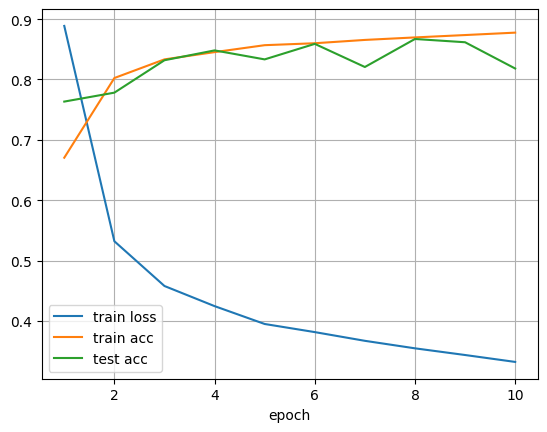

In [12]:
# 调用自定义训练函数
train_ch3_custom(net, train_iter, test_iter, loss, num_epochs, trainer)


In [14]:
# 简洁实现

In [15]:
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # 在第一个全连接层之后添加一个dropout层
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # 在第二个全连接层之后添加一个dropout层
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

In [17]:
# trainer = torch.optim.SGD(net.parameters(), lr=lr)
# d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

epoch 1, loss 1.1730, train acc 0.550, test acc 0.767
epoch 2, loss 0.5891, train acc 0.782, test acc 0.779
epoch 3, loss 0.4926, train acc 0.819, test acc 0.829
epoch 4, loss 0.4448, train acc 0.837, test acc 0.830
epoch 5, loss 0.4240, train acc 0.845, test acc 0.819
epoch 6, loss 0.3981, train acc 0.853, test acc 0.841
epoch 7, loss 0.3834, train acc 0.860, test acc 0.842
epoch 8, loss 0.3667, train acc 0.866, test acc 0.858
epoch 9, loss 0.3566, train acc 0.869, test acc 0.855
epoch 10, loss 0.3472, train acc 0.873, test acc 0.853


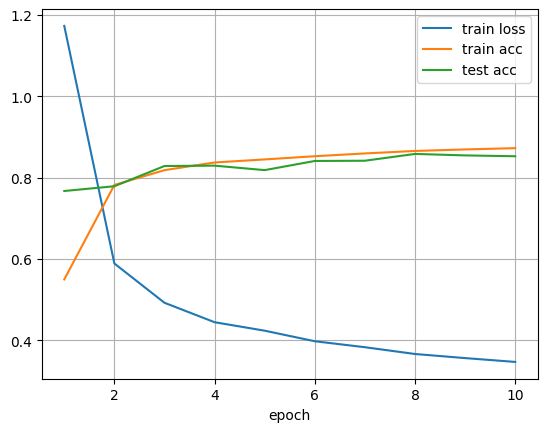

In [16]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3_custom(net, train_iter, test_iter, loss, num_epochs, trainer)